In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

%load_ext autoreload
%autoreload 2

In [2]:
from collections import deque
import requests
from urllib.parse import urljoin
import time
import random

from bs4 import BeautifulSoup
import networkx as nx

In [3]:
from helpers import cache_page, is_cached, get_cached, url_to_filename
from features import extract_visible

In [4]:
from sklearn.externals import joblib
import os

pipeline_path = os.path.join('saved', 'models', 'log_reg_pipeline_general3.pkl')
pipeline = joblib.load(pipeline_path)

In [5]:
status = {
    True: "class_true",
    False: "class_false",
    "fail": "req_failed",
}

class Node:
    # Status one of "class_true", "class_false", "req_failed"
    def __init__(self, url, status, decision_func):
        self.url = url
        self.status = status
        self.decision_func = decision_func
        
    def __str__(self):
        # Remove "https://www." part for clarity
        stripped = "".join(self.url.split('://')[1:])
        return stripped
    
    def __eq__(self, other):
        if isinstance(self, other.__class__):
            return self.url == other.url
        return False
    
    def __hash__(self):
        return hash(self.url)

In [6]:
first_link = "http://online-learning.harvard.edu"

# Queue containing: (url, depth)
queue = deque()
queue.append((first_link, 0, None))

G = nx.DiGraph()
seen_urls = set()

# Params
depth_limit = 6
breadth_limit = 3

print("Running BFS with depth_limit = {} and breadth_limit = {}.".format(depth_limit, breadth_limit))

# Assuming download+sleep=1s
print("Estimated time: {}s".format(np.power(breadth_limit, depth_limit + 1)))
start_time = time.time()

while(len(queue) > 0):
    url, depth, parent_node = queue.popleft()
    
    print(url, depth)
    
    # Add url to seen_urls here, to avoid infinite loop (if the page links to itself)
    seen_urls.add(url)
    
    # Fetch from cache or download the page
    if is_cached(url):
        text = get_cached(url)
        status_code = 200
    else:
        try:
            # Sleep to avoid getting banned
            time.sleep(0.5)
            
            r = requests.get(url)
            status_code = r.status_code
            text = r.text
            soup = BeautifulSoup(text, "lxml")
        except Exception as e:
            print("Exception while requesting / parsing {}".format(url))
            print(e)
            status_code = -1
    

    if status_code != 200:
        node = Node(url, status["fail"], 0)
        G.add_node(node)
    else:
        visible_text = extract_visible(soup)
        
        # Predict label & get strength of prediction
        label = pipeline.predict([visible_text])[0]
        decision_func = pipeline.decision_function([visible_text])[0]

        node = Node(url, status[label], decision_func)
        G.add_node(node)
        
        if depth < depth_limit:
            # Get outgoing url in their absolute form
            out_urls = (urljoin(url, a.get('href', '')) for a in soup.find_all("a"))
            
            # Remove already seen urls
            out_urls = [out_url for out_url in out_urls if out_url not in seen_urls]

            # Keeping only <breadth_limit> out_urls
            if len(out_urls) > breadth_limit:
                out_urls = random.sample(out_urls, breadth_limit)

            queue.extend((out_url, depth + 1, node) for out_url in out_urls)

            
    if parent_node is not None:
        G.add_edge(parent_node, node)
            
print("Done in {}s".format(time.time() - start_time))

Running BFS with depth_limit = 6 and breadth_limit = 3.
Estimated time: 2187s
http://online-learning.harvard.edu 0
http://online-learning.harvard.edu/course/science-cooking-haute-cuisine-soft-matter-science-physics 1
http://online-learning.harvard.edu/series/global-health 1
http://online-learning.harvard.edu/courses/?category[]=7 1
http://online-learning.harvard.edu/course/science-cooking-haute-cuisine-soft-matter-science-physics#nav 2
http://online-learning.harvard.edu/course/super-earths-and-life 2
http://online-learning.harvard.edu/courses/?category[]=7 2
http://online-learning.harvard.edu/courses/?category[]=13 2
http://online-learning.harvard.edu/course/opioid-crisis-america 2
http://online-learning.harvard.edu/courses/?category[]=5 2
http://online-learning.harvard.edu/course/china-part-4-new-national-culture?category[]=7 2
http://online-learning.harvard.edu/course/china-part-10-greater-china-today-peoples-republic-taiwan-and-hong-kong?category[]=7 2
http://online-learning.harvard

FALSE: -0.2942161122813948 online-learning.harvard.edu/author/sarah-griffis
FALSE: -0.27949536345161974 www.pages01.net/harvard/gazette/LPT.url?kn=245395&vs=ZTdjNmFhMjMtOWYwMC00MmI5LWEyNTgtOWE5MTJlZTRlZWJlOzsS1
FALSE: -0.22562873004467837 www.facebook.com/dialog/share?app_id=135898969862440&display=popup&href=http%3A%2F%2Fnews.harvard.edu%2Fgazette%2Fstory%2F2018%2F01%2Fground-breaking-lens-focuses-entire-spectrum-of-light-to-single-point%2F&redirect_uri=http%3A%2F%2Fnews.harvard.edu%2Fgazette%2Fstory%2F2018%2F01%2Fground-breaking-lens-focuses-entire-spectrum-of-light-to-single-point%2F
TRUE: 0.06159585217223518 online-learning.harvard.edu/course/leading-excellence-and-equity-cael-module
TRUE: 0.7977437351360316 online-learning.harvard.edu/course/data-analysis-life-sciences-2-introduction-linear-models-and-matrix-algebra?category[]=9
FALSE: -0.5190785765202142 twitter.com/account/begin_password_reset
FALSE: -0.16909997323297965 online-learning.harvard.edu/course/bostons-crusade-against

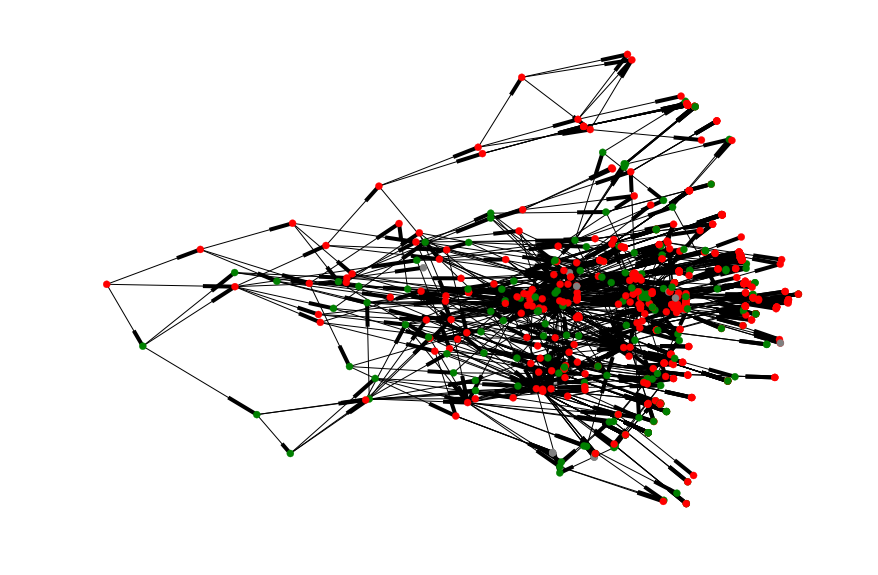

In [7]:
import mpld3
mpld3.enable_notebook()

colors = []

for node in G:
    if node.status == status[True]:
        print("TRUE: {} {}".format(node.decision_func, node))
        colors.append('green')
    elif node.status == status[False]:
        print("FALSE: {} {}".format(node.decision_func, node))
        colors.append('red')
    else:
        # Download error
        colors.append('grey')

fig, ax = plt.subplots(figsize=(15, 10))
nx.draw_kamada_kawai(G, ax=ax, node_color=colors, with_labels=False, node_size=50)

In [8]:
nx.write_gpickle(G, os.path.join('saved', 'graphs', "{}-depth:{}-breadth:{}.pkl"
    .format(url_to_filename(first_link), depth_limit, breadth_limit)))